<a href="https://colab.research.google.com/github/RubingLi123/foster_2023spring/blob/2023sp-master/Module2_Supervised/Supervised_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#If opening in colab run this cell
!git clone https://github.com/CTVisMe/DS4B_Sp24.git
%cd DS4B_Sp24/ClassModules/Module2_Supervised/

Cloning into 'DS4B_Sp24'...
remote: Enumerating objects: 807, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 807 (delta 96), reused 208 (delta 96), pack-reused 598
Receiving objects: 100% (807/807), 147.60 MiB | 17.01 MiB/s, done.
Resolving deltas: 100% (359/359), done.
Updating files: 100% (139/139), done.
/content/DS4B_Sp24/ClassModules/Module2_Supervised


# Supervised segmentation

**Spring 2024 - Instructor:  Chris Volinsky**


**Teaching Assistants: Aditya Deshpande, Stuti Mishra, Krutika Savani**


**Original Notebooks courtesy of Prof. Foster Provost and Rubing Li**

***

## Some general imports

In [2]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks', palette='Set2')

## Predicting who will survive the Titanic

This time we will use a clasic introductory dataset that contains demographic and traveling information for the Titanic passengers. The goal is to predict the survival of these passengers. We will only keep a few variables of interest and transform all of them to numeric variables. We will also drop some outliers.

In [3]:
# Load data
path = "./data/titanic.csv"

df = pd.read_csv(path)[["survived", "pclass", "sex", "age", "fare"]]

# what does the data look like?

df


,survived,pclass,sex,age,fare
0,1.0,1.0,female,29.0000,211.3375
1,1.0,1.0,male,0.9167,151.5500
2,0.0,1.0,female,2.0000,151.5500
3,0.0,1.0,male,30.0000,151.5500
4,0.0,1.0,female,25.0000,151.5500
...,...,...,...,...,...
1305,0.0,3.0,female,NaN,14.4542
1306,0.0,3.0,male,26.5000,7.2250
1307,0.0,3.0,male,27.0000,7.2250
1308,0.0,3.0,male,29.0000,7.8750


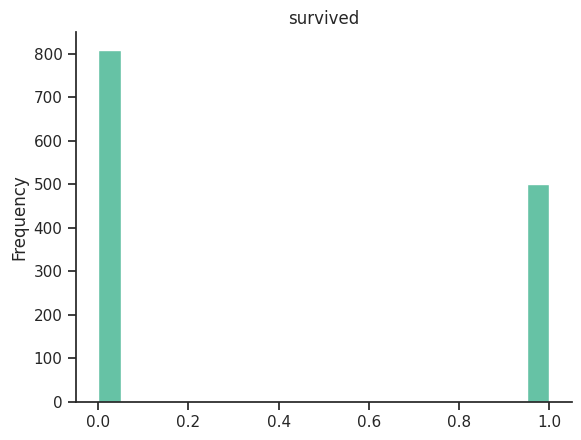

In [4]:
# @title survived

from matplotlib import pyplot as plt
df['survived'].plot(kind='hist', bins=20, title='survived')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [5]:
# look at descriptives

df.describe()

,survived,pclass,age,fare
count,1309.000000,1309.000000,1046.000000,1308.000000
mean,0.381971,2.294882,29.881135,33.295479
std,0.486055,0.837836,14.413500,51.758668
min,0.000000,1.000000,0.166700,0.000000
25%,0.000000,2.000000,21.000000,7.895800
50%,0.000000,3.000000,28.000000,14.454200
75%,1.000000,3.000000,39.000000,31.275000
max,1.000000,3.000000,80.000000,512.329200


It looks like there might be some missing values of some of these variables, becasue they have different counts.  Let's confirm

In [6]:
na_count = df.isna().sum()

na_count

survived      1
pclass        1
sex           1
age         264
fare          2
dtype: int64

Wow.  There are a lot of missing values for the age variable.  We would want to check and see if the missing cases are different in any way.  For starters, are they more or less likely to die?  Lets check.


In [7]:
age_missing = df['age'].isnull().astype(int)

print("Percent missing age",age_missing.mean().round(4))

survived_missing = df[age_missing == 1]['survived'].mean()
survived_non_missing = df[age_missing == 0]['survived'].mean()

print("Missing that Survived", survived_missing.round(4))
print("Non-missing that Survived", survived_non_missing.round(4))


Percent missing age 0.2015
Missing that Survived 0.2776
Non-missing that Survived 0.4082


This is concerning.   In a more thorough analysis of this data, we would study the missing-ness more deeply to see if the missing values are correlated with other attributes, which would potentially add bias to the results  Also, we would consider options for filling in - imputing - the data.

However, in order to discuss the things we want to discuss, we will drop all cases with missing values, which is easy to do in python.   We will drop missing values, which helps us to get to the things we want to discuss.

In [8]:
# read in data again, but dropping NAs with dropna()

df = pd.read_csv(path)[["survived", "pclass", "sex", "age", "fare"]].dropna()

# Transform sex column to a numeric variable
df["female"] = (df.sex == "female").astype(int)
df = df.drop("sex", axis="columns")

# Drop outliers. This is to help the visualization in the next examples.
#df = df[df.fare < 400]

# Take a look at the data
df.head(10)

,survived,pclass,age,fare,female
0,1.0,1.0,29.0000,211.3375,1
1,1.0,1.0,0.9167,151.5500,0
2,0.0,1.0,2.0000,151.5500,1
3,0.0,1.0,30.0000,151.5500,0
4,0.0,1.0,25.0000,151.5500,1
5,1.0,1.0,48.0000,26.5500,0
6,1.0,1.0,63.0000,77.9583,1
7,0.0,1.0,39.0000,0.0000,0
8,1.0,1.0,53.0000,51.4792,1
9,0.0,1.0,71.0000,49.5042,0


We'd like to use data about the passengers to predict whether they will survive. Let's start by taking a look at how well some of the variables "split" the data according to our target.

0.0    0.591388
1.0    0.408612
Name: survived, dtype: float64

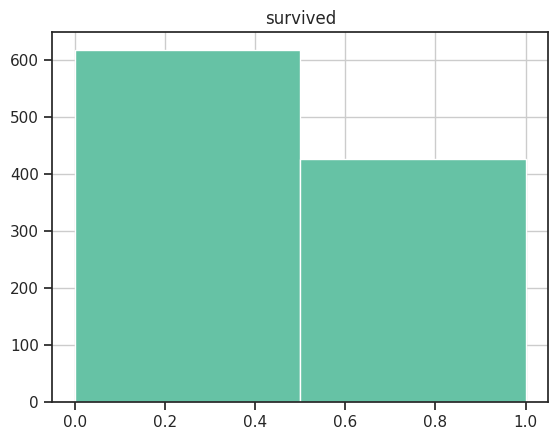

In [9]:
#What is the *base rate* of survival?
df.hist("survived", bins=2)
plt.title("survived")
plt.show
df["survived"].value_counts()/df["survived"].count()

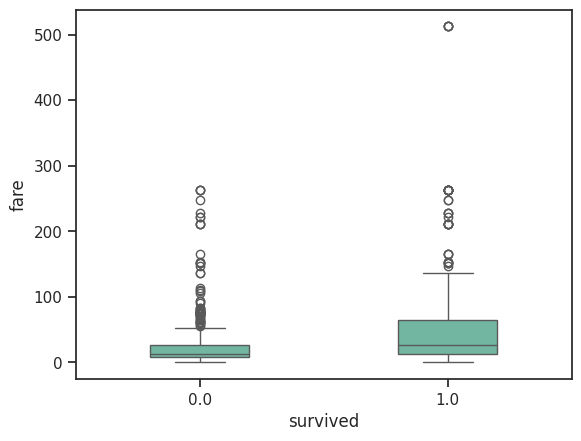

In [10]:
sns.boxplot(x="survived", y="fare", width=0.4, data=df)
plt.show()

Above we see boxplots that show the fare distribution grouped by our target variable (survival). The left boxplot corresponds to people that died and the right one to people that survived. Alternatively, let's plot the distribution of fare according to survival:

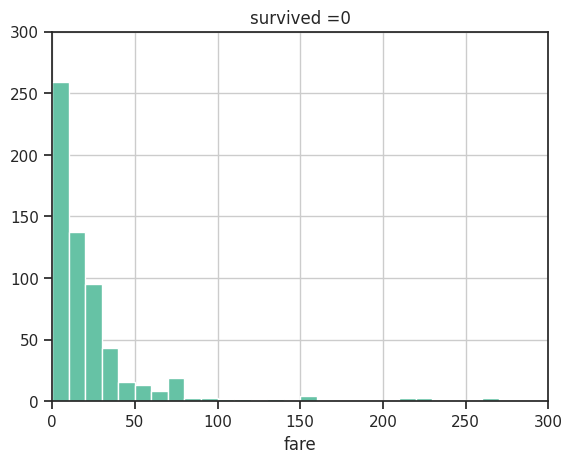

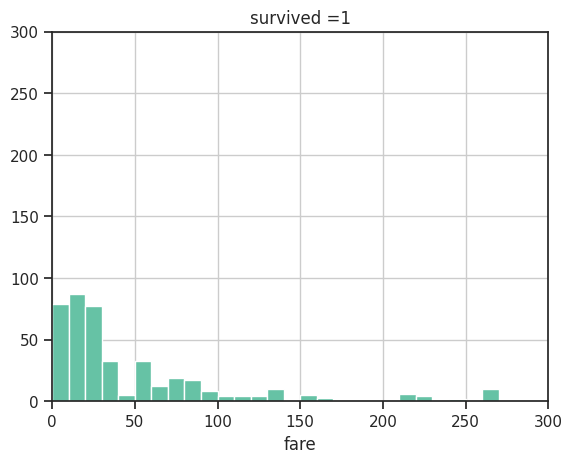

In [11]:
for r in range(2):
    x_max=300 # maybe shrink to 300 to avoid outliers
    hist = df[df.survived == r].hist('fare',bins=range(0,x_max,10))
    plt.title("survived =" + str(r))
    plt.ylim(0,300)
    plt.xlabel("fare")
    plt.xlim([0,x_max])
    plt.show()

On might conclude from this that people that paid less are less likely to survive. **What do you think is a good split point?**. How effective is this threshold? Let's quantify it!

***


**Entropy** ($H$) and **information gain** ($IG$) are useful tools for measuring the effectiveness of a split on the values of one variable for giving information on the value of another variable. Entropy measures how random data is, information gain is a measure of the reduction in randomness after performing a split.

<table style="border: 0px">
<tr style="border: 0px">
<td style="border: 0px"><img src="https://github.com/pearl-yu/foster_2022fall/blob/2022-master/Module2_Supervised/images/dsfb_0304.png?raw=1" height=40% width=40%>
Figure 3-4. Splitting the "write-off" sample into two segments, based on splitting the Balance attribute (account balance) at 50K.</td>
</tr>
</table>

Given the data, it is fairly straight forward to calculate both of these quantities.

##### Functions to get the entropy and IG

In [12]:
def entropy(target_column):
    """
        computes -sum_i p_i * log_2 (p_i) for each i
    """
    # get the counts of each target value
    target_counts = target_column.value_counts().astype(float).values
    total = target_column.count()
    # compute probas
    probas = target_counts/total
    # p_i * log_2 (p_i)
    entropy_components = probas * np.log2(probas)
    # return negative sum
    return - entropy_components.sum()

def information_gain(df, info_column, target_column, threshold):
    """
        computes H(target) - H(target | info > thresh) - H(target | info <= thresh)
    """
    # split data
    data_above_thresh = df[df[info_column] > threshold]
    data_below_thresh = df[df[info_column] <= threshold]
    # get entropy
    H = entropy(df[target_column])
    entropy_above = entropy(data_above_thresh[target_column])
    entropy_below = entropy(data_below_thresh[target_column])
    # compute weighted average
    ct_above = data_above_thresh.shape[0]
    ct_below = data_below_thresh.shape[0]
    tot = float(df.shape[0])
    return H - entropy_above*ct_above/tot - entropy_below*ct_below/tot

Now that we have a way of calculating $H$ and $IG$, let's test our prior guess as a good split point as a split on fare allows us to predict people who will survive.

In [13]:
threshold = 60
prior_entropy = entropy(df["survived"])
IG = information_gain(df, "fare", "survived", threshold)
print ("IG of %.4f using a threshold of %.2f given a prior entropy of %.4f" % (IG, threshold, prior_entropy))

IG of 0.0394 using a threshold of 60.00 given a prior entropy of 0.9758


How good was our guess? Let's loop through all possible splits on fare and see what is the best!

In [14]:
def best_threshold(df, info_column, target_column, criteria=information_gain):
    maximum_ig = 0
    maximum_threshold = 0

    for thresh in df[info_column].unique():
        IG = criteria(df, info_column, target_column, thresh)
        if IG > maximum_ig:
            maximum_ig = IG
            maximum_threshold = thresh

    return (maximum_threshold, maximum_ig)

col = "age"
maximum_threshold, maximum_ig = best_threshold(df, col, "survived")

print ("the maximum IG we can achieve splitting on %s is %.4f using a thresh of %.2f" % (col, maximum_ig, maximum_threshold))

the maximum IG we can achieve splitting on age is 0.0115 using a thresh of 8.00


Other observed features may also give us (strong) clues about survival.

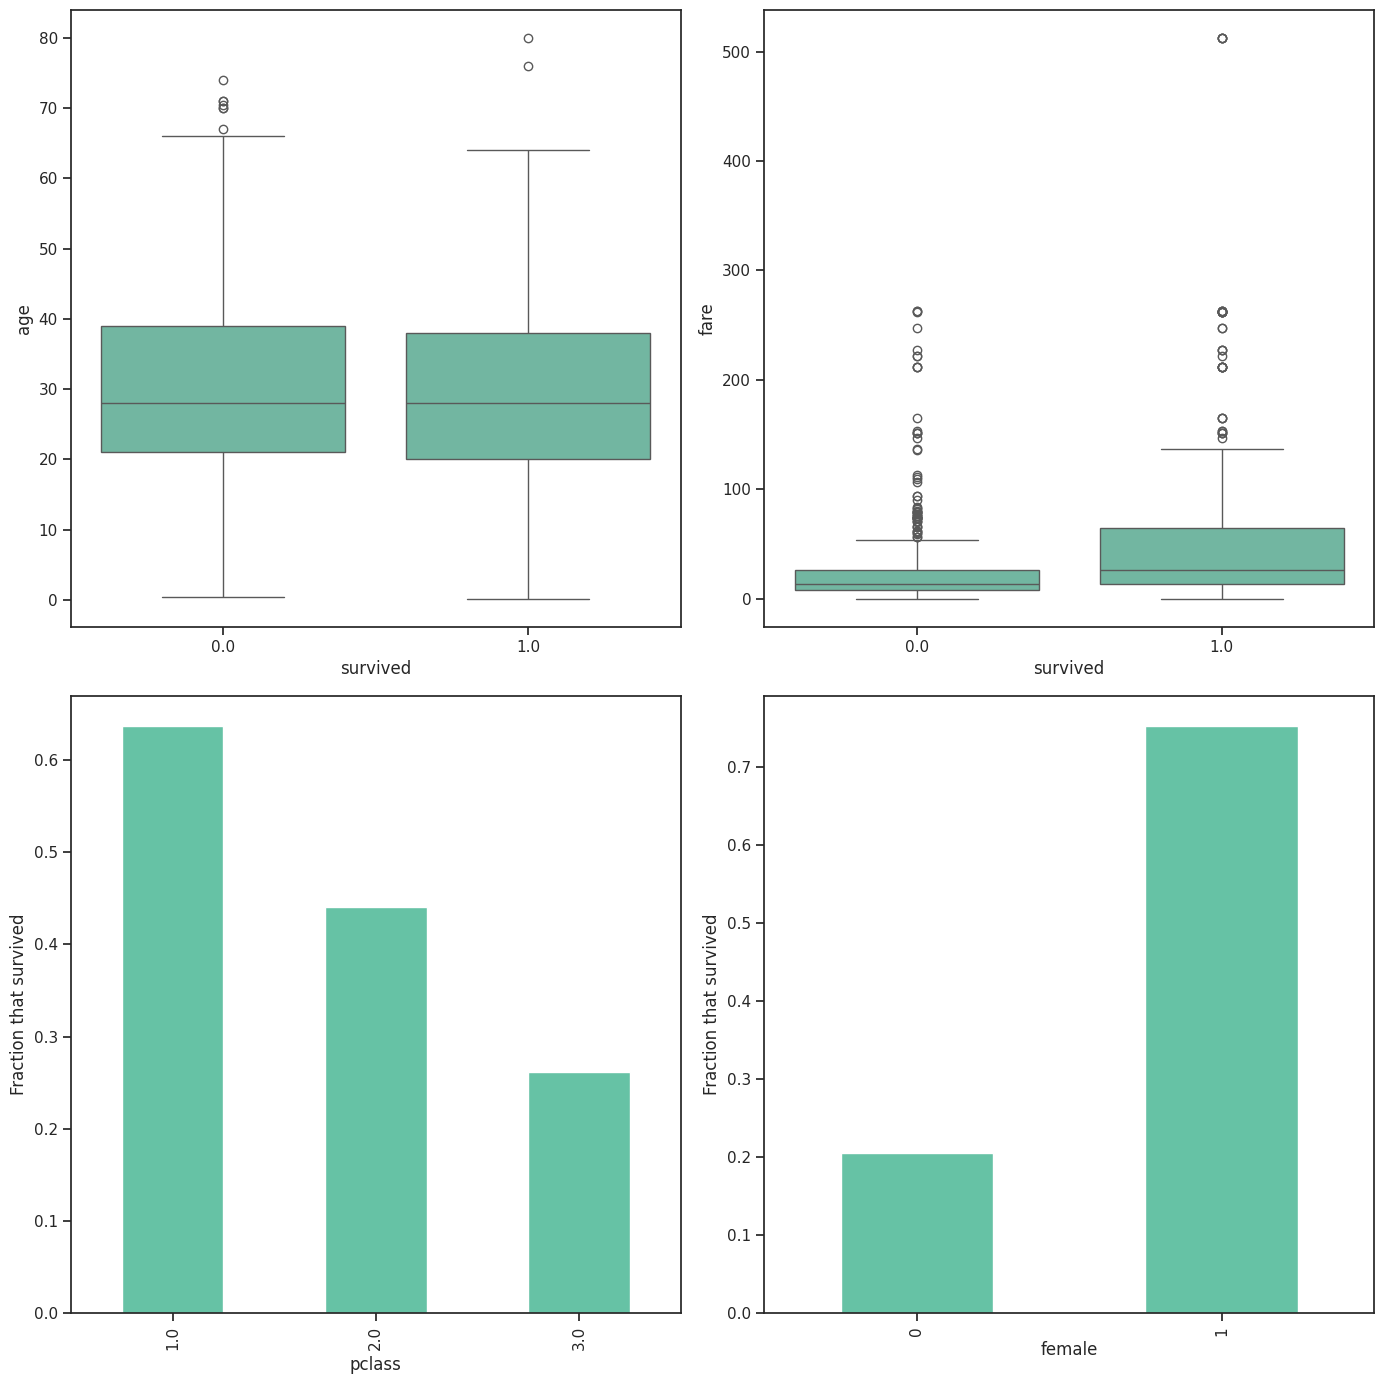

In [15]:
# Names of different columns
categorical_cols = ["pclass", "female"]
continuous_cols = ["age", "fare"]
target_col = "survived"
predictor_cols = categorical_cols + continuous_cols

# This is to plot everything in a 2x2 space
rows, cols = 2, 2
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(7*cols, 7*rows))
axs = axs.flatten()
posn = 0

# Plot continous features
for col in continuous_cols:
    sns.boxplot(x=target_col, y=col, data=df, ax=axs[posn])
    axs[posn].set_ylabel(col)
    axs[posn].set_title("")
    posn += 1

# Plot categorical features
for col in categorical_cols:
    df.groupby(col)[target_col].mean().plot(kind="bar", ax=axs[posn])
    axs[posn].set_ylabel("Fraction that survived")
    posn += 1

plt.tight_layout()

So, then ... what feature gives the most effective split?

In [16]:
def best_split(df, info_columns, target_column, criteria=information_gain):
    maximum_ig = 0
    maximum_threshold = 0
    maximum_column = ""

    for info_column in info_columns:
        thresh, ig = best_threshold(df, info_column, target_column, criteria)

        if ig > maximum_ig:
            maximum_ig = ig
            maximum_threshold = thresh
            maximum_column = info_column

    return maximum_column, maximum_threshold, maximum_ig

max_col, max_threshold, max_ig = best_split(df, predictor_cols, "survived")

print ("The best column to split on is %s giving us a IG of %.4f using a thresh of %.2f" % (max_col, max_ig, max_threshold))

The best column to split on is female giving us a IG of 0.2154 using a thresh of 0.00


### The Classification Tree: Recursive Splitting

Of course, splitting the data one time sometimes isn't enough to make accurate predictions. However, we can continue to split the data recursively ("recursive partitioning"), building a tree-structured model that may give better results.

Tree-structured models are one of the most popular and powerful sorts of machine learning algorithm.  They include classification or class-probability estimation trees (aka "decision trees"), regression trees, and many more complex models built by combining tree-structured models, such as random forests and gradient boosted models (which usually combine trees).

What are some other ways you might consider splitting the data?

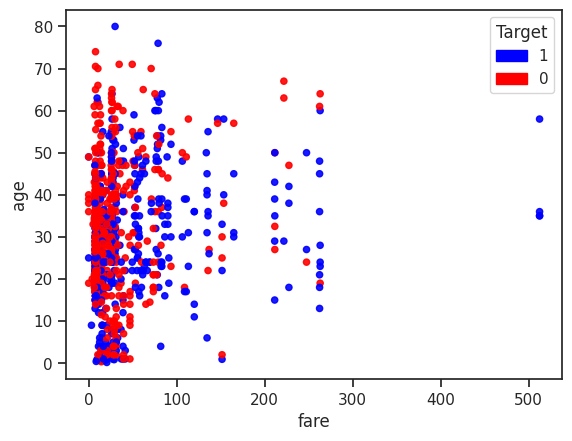

In [17]:
import matplotlib.patches as mpatches

cmap = {1: 'blue', 0: 'red'}
df.plot(kind="scatter", x="fare", y="age", c=[cmap[c] for c in df[target_col]],alpha=0.9)
plt.legend(handles=[mpatches.Patch(color=cmap[k], label=k) for k in cmap], loc=1, title="Target", frameon=True)
plt.show()

Rather than build a classification tree from scratch (think if you could now do this!) let's use sklearn's implementation which includes some additional functionality.

In [18]:
from sklearn.tree import DecisionTreeClassifier
# Define the model (tree)
# ---> This is really both defining the model AND the ML algorithm to learn (train) it!
decision_tree = DecisionTreeClassifier(max_depth=None, criterion="entropy")   # Look at those 2 arguments !!!
# Tell the model what data to use and then train the model
decision_tree.fit(df[predictor_cols], df["survived"])

DecisionTreeClassifier(criterion='entropy')

We now have a classification tree, let's visualize the results!

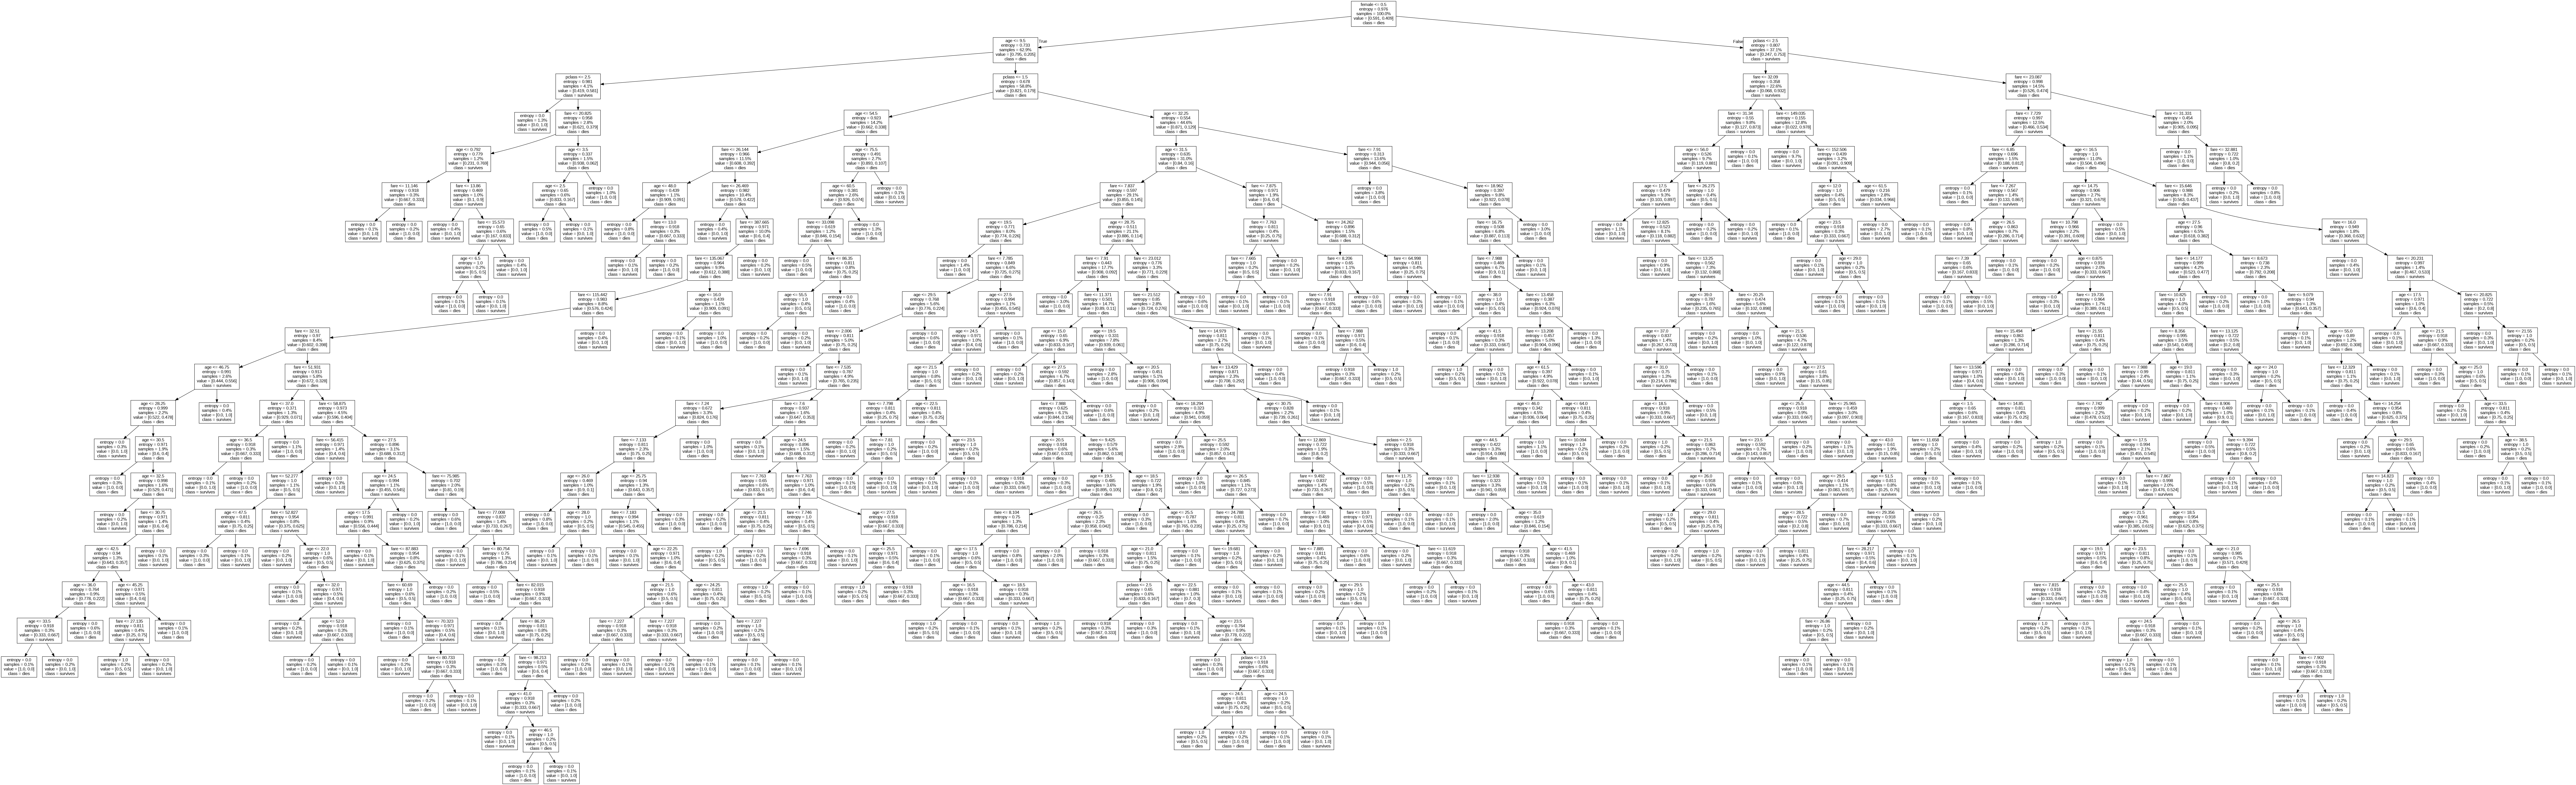

In [19]:
from IPython.display import Image
from sklearn.tree import export_graphviz
# "homemade" function to visualize trees using graphviz library
# can also use matplotlib "plot_tree"
def visualize_tree(decision_tree, feature_names, class_names, directory="./images", name="tree",proportion=True):
    # Export our decision tree to graphviz format
    dot_name = "%s/%s.dot" % (directory, name)
    dot_file = export_graphviz(decision_tree, out_file=dot_name,
                               feature_names=feature_names, class_names=class_names,proportion=proportion)
    # Call graphviz to make an image file from our decision tree
    image_name = "%s/%s.png" % (directory, name)
    os.system("dot -T png %s -o %s" % (dot_name, image_name))
    # Return the .png image so we can see it
    return Image(filename=image_name)

visualize_tree(decision_tree, predictor_cols, ["dies", "survives"])

Whoa!  This will almost surely overfit!  There are many ways to restrict a tree to something more reasonable, including:
- `max_depth` -  how many layers to the tree
- `min_samples_split` - the minimum number of samples needed at a node to split (default =2)
- `min_samples_leaf` - the minimum number of samples that can be in a leaf node
- `max_leaf_nodes` - limits the number of leaf nodes in the overall tree
- `min_impurity_decrease` - restricts the ability of the tree to create trivial splits

Lets make things easier by setting max_depth to 3 - then visualize the tree and explore it to see what is important

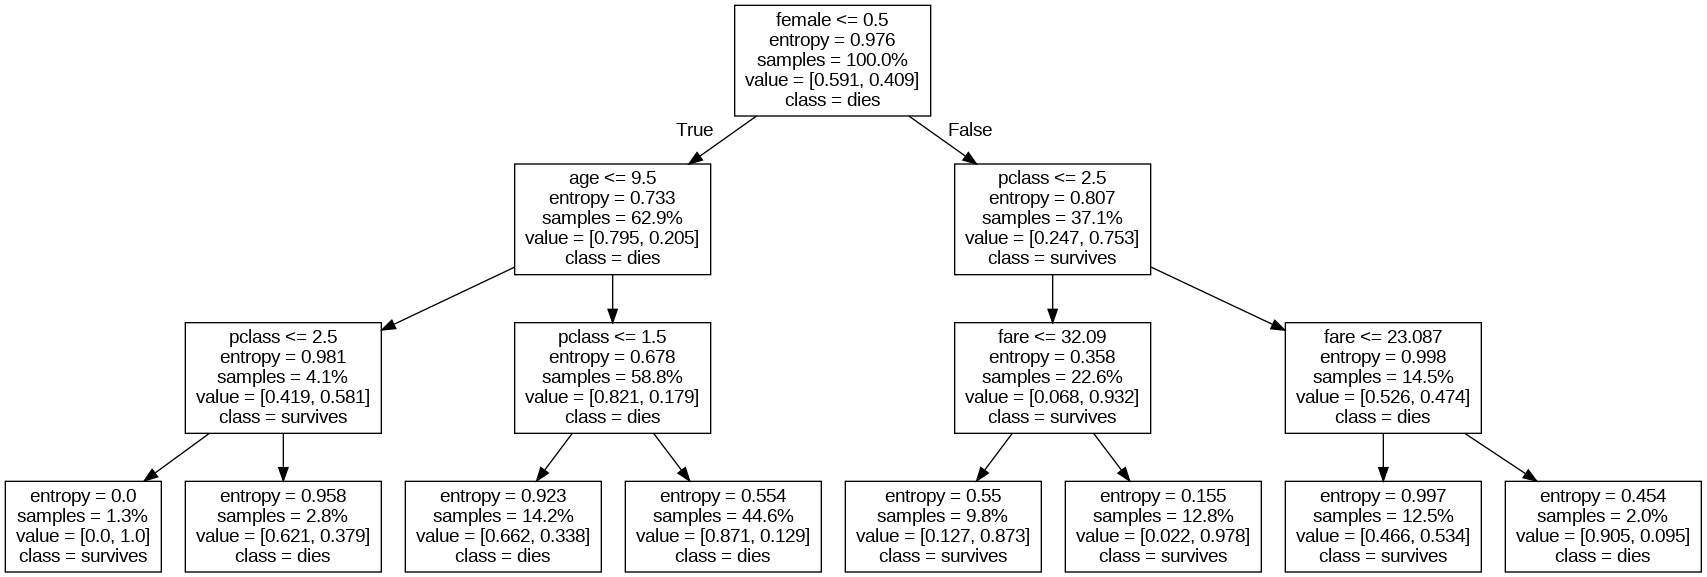

In [20]:
decision_tree = DecisionTreeClassifier(max_depth=3, criterion="entropy")   # Look at those 2 arguments !!!
# Tell the model what data to use and then train the model
decision_tree.fit(df[predictor_cols], df["survived"])

visualize_tree(decision_tree, predictor_cols, ["dies", "survives"])


How good is this model?  Calculate the accuracy - although we know this might not be the best metric*, it is still useful!!
It simply means the percent of cases that are correctly predicted in the leaf nodes of the tree.

* because it is not measured on a hold-out set
* also, what is the base-rate?

In [21]:
from sklearn import metrics
accuracy = metrics.accuracy_score(decision_tree.predict(df[predictor_cols]),df["survived"])
print ( "Accuracy = ", accuracy.round(4))

Accuracy =  0.8086


Let's look at a model using only `"age"` and `"fare"`, so we can plot the **DECISION SURFACE!!**

More details for this graph: [sklearn decision surface](https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


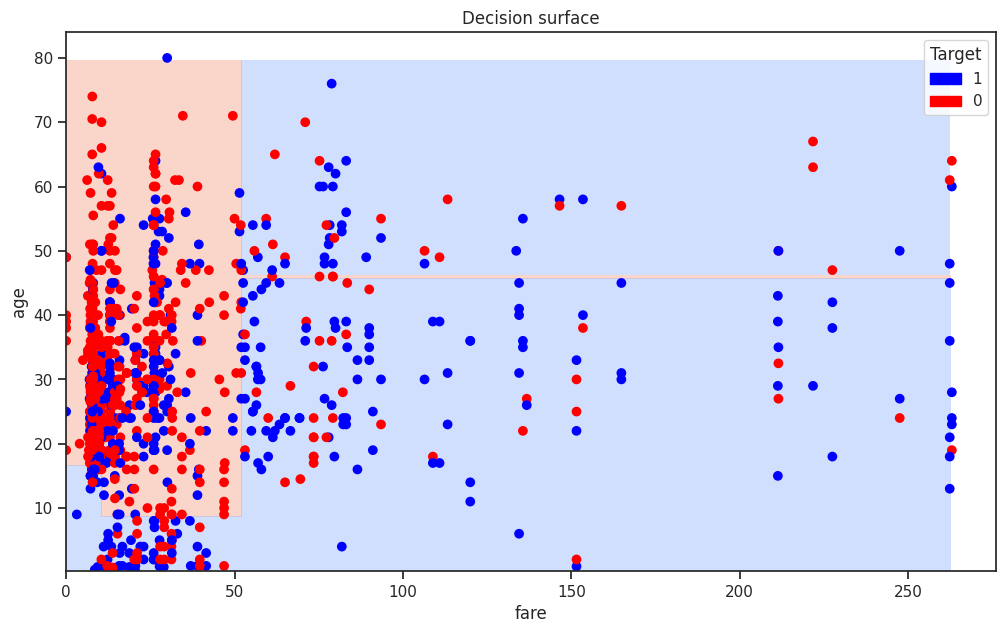

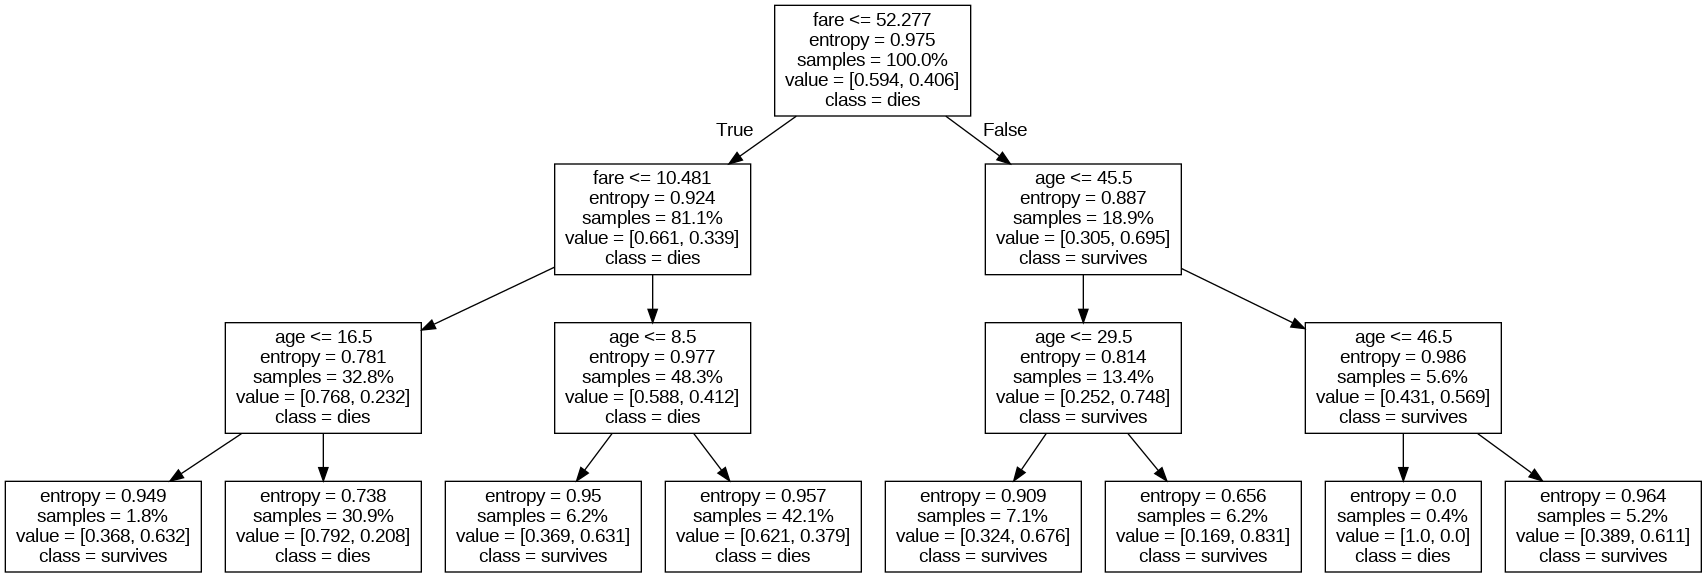

In [22]:
def Decision_Surface(data, col1, col2, target, model, probabilities=False):
    # Get bounds
    x_min, x_max = data[col1].min(), data[col1].max()
    y_min, y_max = data[col2].min(), data[col2].max()
    # Create a mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max,0.5))
    meshed_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    # Get predictions for the mesh
    tdf = data[[col1, col2]]
    model.fit(tdf, target)
    if probabilities:
        Z = model.predict_proba(meshed_data)[:, 1].reshape(xx.shape)
    else:
        Z = model.predict(meshed_data).reshape(xx.shape)
    # Chart details
    plt.figure(figsize=[12,7])
    plt.title("Decision surface")
    plt.xlabel(col1)
    plt.ylabel(col2)
    if probabilities:
        # Color-scale on the contour (surface = separator)
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm_r, alpha=0.4)
    else:
        # Only a curve/line on the contour (surface = separator)
        cs = plt.contourf(xx, yy, Z, levels=[-1,0,1], cmap=plt.cm.coolwarm_r, alpha=0.4)
    # Plot scatter plot
    cmap = {1: 'blue', 0: 'red'}
    colors = [cmap[c] for c in df[target_col]]
    plt.scatter(data[col1], data[col2], color=colors)
    # Build legend
    plt.legend(handles=[mpatches.Patch(color=cmap[k], label=k) for k in cmap], loc="best", title="Target", frameon=True)
    plt.show()

# Drop the big fare outliers to help the visualization.
df = df[df.fare < 400]

# Can change depths here
tree_depth=3
model = DecisionTreeClassifier(max_depth=tree_depth, criterion="entropy")
Decision_Surface(df, "fare", "age", df.survived, model)

## just the model on fare and age!!
visualize_tree(model, ["fare","age"], ["dies", "survives"])


### Class Exercise:  Building a model using training and test sets

Use the sklearn function train_test_split to create a training and test set with an 80/20 split.  Use a random_state argument to make sure you can run with the same split repeatedly

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### define X and y (as before)

X = df[predictor_cols]
y = df["survived"]

### create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=111)

### fit the model on the training set (use depth=2)
depth=2
decision_tree = DecisionTreeClassifier(max_depth=depth, criterion="entropy")
decision_tree.fit(X_train, y_train)

### apply the model to the test set using .predict
y_pred = decision_tree.predict(X_test)

### find the accuracy using metrics.accuracy_score()
accuracy = metrics.accuracy_score(y_pred, y_test).round(4)
accuracy






0.799

Now we will use our training/test split to help us determine what is the best depth for the tree.  Using a for loop, fit trees to your training set of max_depth = [2,3,4,5,6] and report the accuracy on the test set for each.

What is the optimal depth?
(Optional - change `random_state` and run again?)

In [24]:
depth_vals = [2,3,4,5,6,7,8]
for i in depth_vals:
  depth = i
  decision_tree = DecisionTreeClassifier(max_depth=depth, criterion="entropy")   # Look at those 2 arguments !!!
  # Tell the model what is the "training" data and then train it
  decision_tree.fit(X_train, y_train)

  y_pred = decision_tree.predict(X_test)

  accuracy = metrics.accuracy_score(y_pred, y_test).round(4)
  print("max_depth = ",i,"Accuracy:", accuracy)

max_depth =  2 Accuracy: 0.799
max_depth =  3 Accuracy: 0.7895
max_depth =  4 Accuracy: 0.7943
max_depth =  5 Accuracy: 0.823
max_depth =  6 Accuracy: 0.8038
max_depth =  7 Accuracy: 0.799
max_depth =  8 Accuracy: 0.7799


Once we know the optimal depth, if this were a real-world problem, before we apply it to the real world, we would re-fit our model to the FULL data set.  (This is a contrived case because there is no actual real-world application to predicting Titanic deaths 😱 ).  But lets do it anyway.


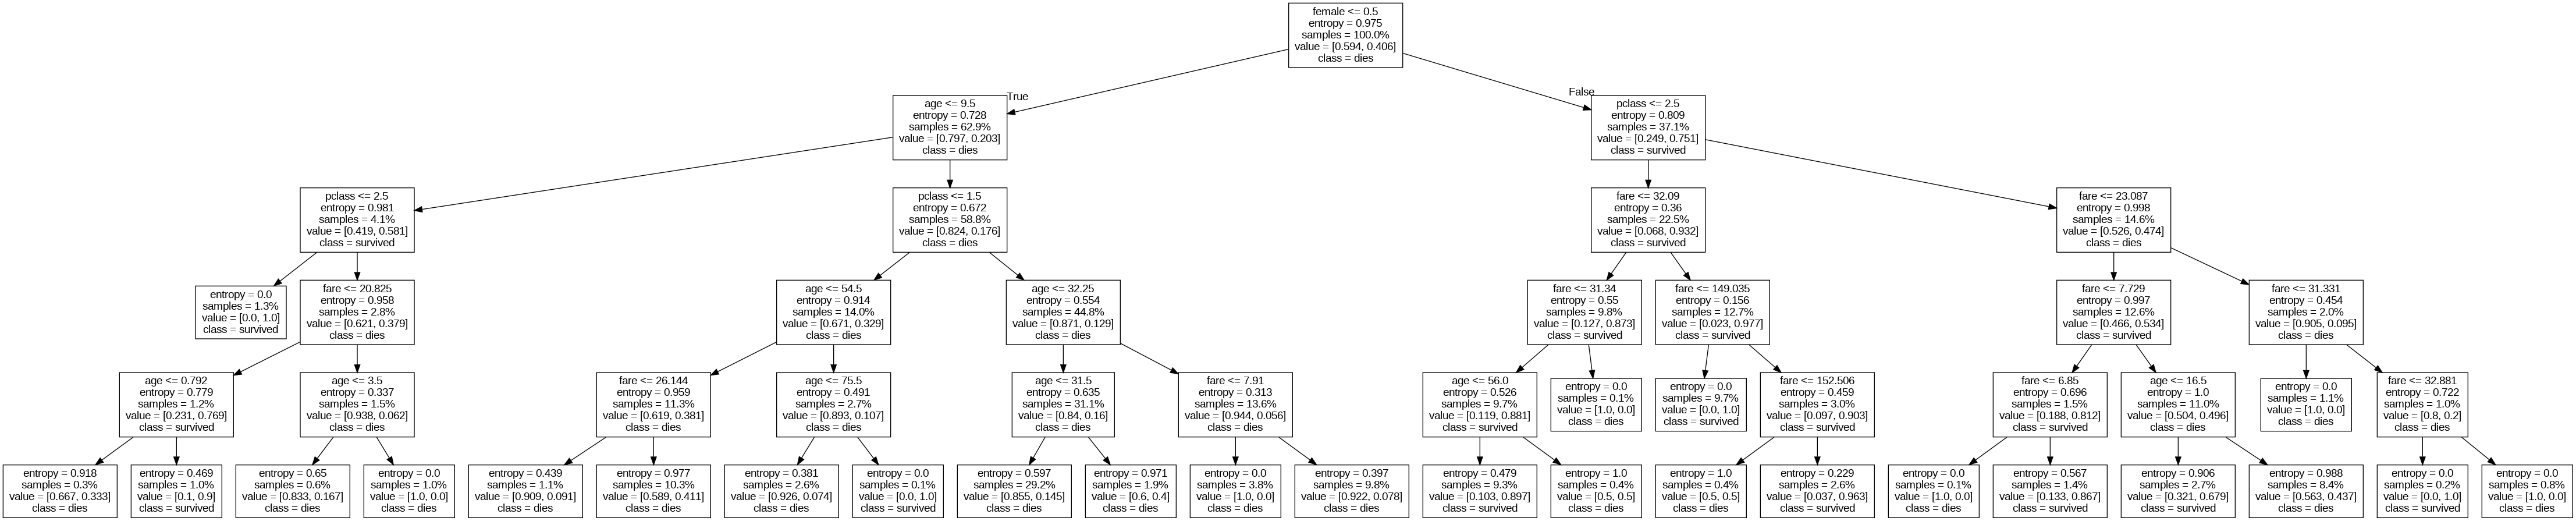

In [25]:
# now that we know the best max_depth, to find the best tree...apply it to the ENTIRE data set
opt_depth = 5
tree_final = DecisionTreeClassifier(max_depth=opt_depth, criterion="entropy")
tree_final.fit(X,y)
visualize_tree(tree_final, predictor_cols, ["dies", "survived"])


You can use `.feature_importances_` applied to the tree model to get the importance of each feature.  Find the importances of the four attributes and plot as a barplot.

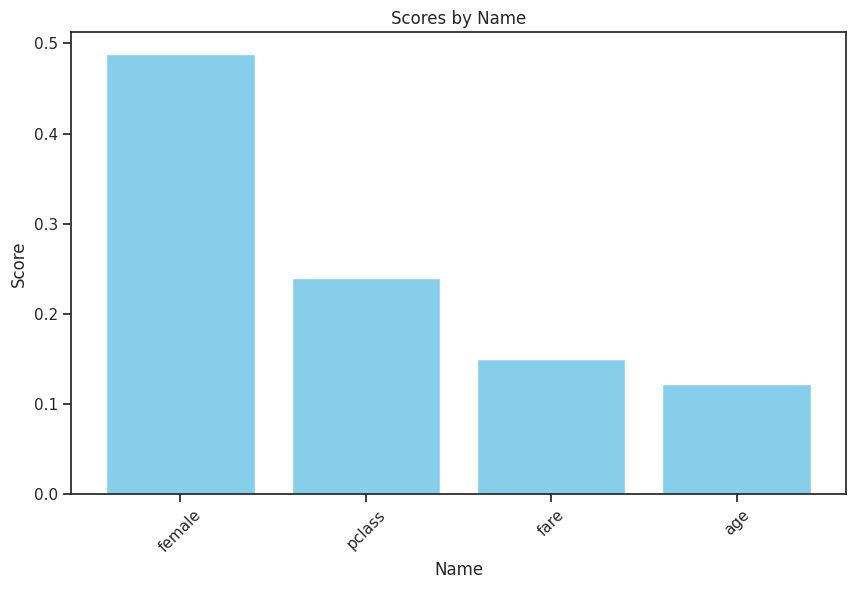

In [26]:
# find feature importances and plot

# print(predictor_cols, importances.round(4))

scores = tree_final.feature_importances_
names=predictor_cols


sorted_pairs = sorted(zip(scores, names), reverse=True)
sorted_scores, sorted_names = zip(*sorted_pairs)

# Create the bar plot
plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size as needed
plt.bar(sorted_names, sorted_scores, color='skyblue')  # You can change the color

# Add title and labels
plt.title('Scores by Name')
plt.xlabel('Name')
plt.ylabel('Score')

# Display the plot
plt.xticks(rotation=45)  # Rotate names to prevent overlap
plt.show()

## Another example for you to try

Tayko software example [Shmueli].

Task is to predict whether the person made a Purchase  (0,1) given 24 attributes including the source catalog the customer received (encoded in 15 "source" variables) and other customer attributes.  

In [27]:
path = "./data/Tayko.csv"

# read in using read_csv

df=pd.read_csv(path)
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   sequence_number       2000 non-null   int64
 1   US                    2000 non-null   int64
 2   source_a              2000 non-null   int64
 3   source_c              2000 non-null   int64
 4   source_b              2000 non-null   int64
 5   source_d              2000 non-null   int64
 6   source_e              2000 non-null   int64
 7   source_m              2000 non-null   int64
 8   source_o              2000 non-null   int64
 9   source_h              2000 non-null   int64
 10  source_r              2000 non-null   int64
 11  source_s              2000 non-null   int64
 12  source_t              2000 non-null   int64
 13  source_u              2000 non-null   int64
 14  source_p              2000 non-null   int64
 15  source_x              2000 non-null   int64
 16  source

Now do the same exercise here that we did above, splitting 80/20 into train/test, and use that to identify the optimal split, and the accuracy of the optimal split.

In [28]:
# build a tree and see accuracy on full (training) data

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# make sure to remove ["sequence_number","Purchase","Spending"] when creating your X data
# target variable is "Purchase"

X = df.drop(["sequence_number","Purchase","Spending"],axis=1)
y = df["Purchase"]

depth = 10 #overfit on purpose!

decision_tree = DecisionTreeClassifier(max_depth=depth, criterion="entropy")   # Look at those 2 arguments !!!
# Tell the model what is the "training" data and then train it
decision_tree.fit(X, y)
metrics.accuracy_score(decision_tree.predict(X), y)

0.845

In [29]:
# Create train and test sets...


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=123)


In [30]:
# cycle through depth vals and find the one with the best accuracy on the test data
depth_vals = [2,3,4,5,6,7,8,9,10]
for i in depth_vals:
  ### enter code here...
  maxi_depth = i
  decision_tree = DecisionTreeClassifier(max_depth=maxi_depth, criterion="entropy")   # Look at those 2 arguments !!!
  # Tell the model what is the "training" data and then train it
  decision_tree.fit(X_train, y_train)

  y_pred = decision_tree.predict(X_test)

  accuracy = metrics.accuracy_score(y_pred, y_test).round(4)
  print("max_depth = ",i,"Accuracy:", accuracy)

max_depth =  2 Accuracy: 0.7175
max_depth =  3 Accuracy: 0.7525
max_depth =  4 Accuracy: 0.7
max_depth =  5 Accuracy: 0.7775
max_depth =  6 Accuracy: 0.79
max_depth =  7 Accuracy: 0.7825
max_depth =  8 Accuracy: 0.7675
max_depth =  9 Accuracy: 0.7725
max_depth =  10 Accuracy: 0.7875


In [31]:
from sklearn.model_selection import cross_val_score

depth_vals = list(range(2, 10))

# Assuming X and y are your features and target variable
for depth in depth_vals:
    decision_tree = DecisionTreeClassifier(max_depth=depth, criterion="entropy")

    # Perform 5-fold cross-validation
    scores = cross_val_score(decision_tree, X, y, cv=10, scoring='accuracy',verbose=1)

    # Calculate the mean accuracy across all folds
    mean_accuracy = np.mean(scores).round(4)


    print("max_depth = ", depth, "Mean CV Accuracy:", mean_accuracy)

max_depth =  2 Mean CV Accuracy: 0.699
max_depth =  3 Mean CV Accuracy: 0.742
max_depth =  4 Mean CV Accuracy: 0.7305
max_depth =  5 Mean CV Accuracy: 0.772
max_depth =  6 Mean CV Accuracy: 0.7835
max_depth =  7 Mean CV Accuracy: 0.786
max_depth =  8 Mean CV Accuracy: 0.7715
max_depth =  9 Mean CV Accuracy: 0.7895


In [32]:
visualize_tree(decision_tree,X.columns,["no","yes"])

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.